In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import sys
sys.path.append('../')

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k, evaluete_rec
from src.utils import prefilter_items
from src.recommenders import MainRecommender
from src.myf import reduction_memory

from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../data/retail_train.csv')
data = reduction_memory(data)

item_features = pd.read_csv('../data/product.csv')
item_features = reduction_memory(item_features)

user_features = pd.read_csv('../data/hh_demographic.csv')

before:		230.09 MB
after:		141.41 MB
reduсed:	88.68 MB
before:		5.17 MB
after:		4.25 MB
reduсed:	0.92 MB


In [3]:
# column processing
# column names in lower case
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

# rename columns
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

In [4]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)

val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) & 
                      (data['week_no'] < data['week_no'].max() - val_lvl_2_size_weeks)]

data_train_lvl_2 = data_val_lvl_1.copy() # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_val_lvl_1.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0
2107469,2021,40618753059,594,856060,1,1.77,443,-0.09,101,86,0.0,0.0
2107470,2021,40618753059,594,869344,1,1.67,443,-0.22,101,86,0.0,0.0
2107471,2021,40618753059,594,896862,2,5.00,443,-2.98,101,86,0.0,0.0


In [5]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data=data_train_lvl_1,
                                   item_features=item_features)

data_train_lvl_1.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,price
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0,1.39
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0,0.82
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0,0.99
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0,1.21
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0,1.50


In [6]:
n_items_after = data_train_lvl_1['item_id'].nunique()
print(f'Decreased # items from {n_items_before} to {n_items_after}')

Decreased # items from 83685 to 5001


In [7]:
recommender = MainRecommender(data_train_lvl_1)

In [8]:
recommender.get_als_recommendations(user=2375, N=5)

[923746, 845208, 899624, 1037863, 844179]

In [9]:
recommender.get_own_recommendations(user=2375, N=5)

[1036501, 1079023, 1085983, 907099, 910439]

In [10]:
recommender.get_similar_items_recommendation(user=2375, N=5)

[868764, 889731, 1055646, 1046545, 845208]

In [11]:
recommender.get_similar_users_recommendation(user=2375, N=5)

[869195, 888650, 1015296, 894439, 822677]

# Задание 1

### A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?

- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

In [12]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns = ['user_id', 'actual']
result_lvl_1 = result_lvl_1[result_lvl_1['user_id'].isin(data_train_lvl_1['user_id'])]
result_lvl_1.head()

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96..."
4,7,"[836281, 843306, 845294, 914190, 920456, 93886..."


### B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  

In [13]:
K = 5, 20, 50, 100, 200, 500 

k_dict = {}

for k in K:
    
    result_lvl_1['similar_items_recommendation'] = result_lvl_1['user_id'].apply(
        lambda x: recommender.get_similar_items_recommendation(user=x, N=k)
    )# apply

    result_lvl_1['als_recommendations'] = result_lvl_1['user_id'].apply(
        lambda x: recommender.get_als_recommendations(user=x, N=k)
    )# apply

    result_lvl_1['own_recommendations'] = result_lvl_1['user_id'].apply(
        lambda x: recommender.get_own_recommendations(user=x, N=k)
    )# apply
    
    k_dict[k] = evaluete_rec(data=result_lvl_1, 
                              true='actual',
                              metric='recall@k',
                              k=k)
    
result_lvl_1.head()

,user_id,actual,similar_items_recommendation,als_recommendations,own_recommendations
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[12352293, 999999, 840361, 9526410, 7135183, 9...","[1082212, 1062572, 1028166, 1098692, 912137, 1...","[856942, 9297615, 5577022, 1074612, 9655212, 9..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[8090509, 1133018, 5569845, 1106523, 985999, 8...","[5569230, 854852, 908846, 1041259, 1009449, 11...","[1076580, 911974, 826784, 1083296, 838136, 820..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[835530, 930344, 856772, 1055425, 1133312, 880...","[902172, 846550, 987044, 891423, 822178, 10589...","[891423, 910109, 887003, 1121367, 951821, 1115..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[999999, 904360, 825541, 845208, 948650, 55698...","[1082185, 1024306, 878996, 930118, 965267, 105...","[13003092, 1119051, 9911484, 8203834, 1108094,..."
4,7,"[836281, 843306, 845294, 914190, 920456, 93886...","[999999, 1038985, 1015247, 1094955, 836793, 11...","[912553, 860975, 857390, 853643, 1135886, 9882...","[845814, 1075524, 1097544, 1112957, 9338009, 6..."


In [14]:
eval_recall = pd.DataFrame(k_dict, index=['similar_items', 'als', 'own']).T
eval_recall

,similar_items,als,own
5,0.010202,0.015777,0.028254
20,0.027989,0.042128,0.064490
50,0.053545,0.076982,0.104058
100,0.086475,0.119880,0.153365
200,0.139516,0.175383,0.230184
500,0.241703,0.276087,0.342583


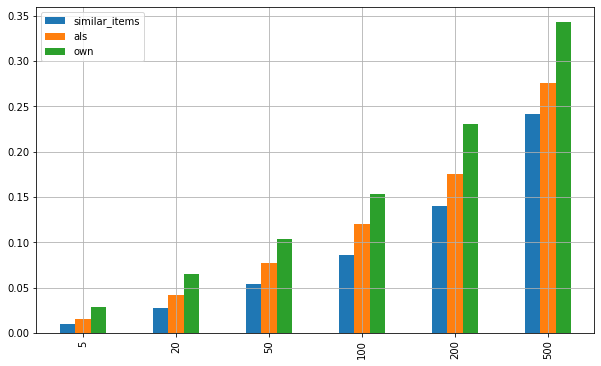

In [15]:
eval_recall.plot(kind='bar', figsize=(10,6))
plt.grid()
plt.show()

##### Дают ли own recommendtions + top-popular лучший recall?

##### ответ:
Тесты показали, что комбинация __own recommendtions + top-popular__ не дает лучший recall

##### ответ:
Видно, что чем больше k тем выше показатель recall@k

### C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

Чем больше k тем больше претедентов будет подобрано, теп больше претендентов будет предсказано, для повышения показателя нужно повышать количество кандидатов. Но врят ли это будет разумно для рекомендаций пользователям, там дубет достаточно до 5 претенденетов.

# Задание 2.

Обучите модель 2-ого уровня, при этом:

#### - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

In [16]:
def featuring(data):
    data['price_for_one'] = data['price'] / data['quantity']
    data['cost_to_disc'] = data['price'] - (data['price'] * data['retail_disc'])
    
    return data

In [17]:
# prefiltering
data_train_lvl_2 = prefilter_items(data=data_train_lvl_2, item_features=item_features)
# featuring
data_train_lvl_2 = featuring(data=data_train_lvl_2)

data_train_lvl_2.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,price,price_for_one,cost_to_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0,1.00,1.00,1.2900
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0,0.99,0.99,0.9900
2107469,2021,40618753059,594,856060,1,1.77,443,-0.09,101,86,0.0,0.0,1.77,1.77,1.9293
2107470,2021,40618753059,594,869344,1,1.67,443,-0.22,101,86,0.0,0.0,1.67,1.67,2.0374
2107471,2021,40618753059,594,896862,2,5.00,443,-2.98,101,86,0.0,0.0,2.50,1.25,9.9500


In [18]:
# learning
recommender2 = MainRecommender(data_train_lvl_2)

#### - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2

In [19]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns = ['user_id', 'actual']

result_lvl_2 = result_lvl_2[result_lvl_2['user_id'].isin(data_train_lvl_2['user_id'])]
result_lvl_2.head()

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412..."
5,9,"[864335, 990865, 1029743, 9297474, 10457112, 8..."


In [20]:
result_lvl_2_1 = result_lvl_2[result_lvl_2['user_id'].isin(data_train_lvl_1['user_id'])]
result_lvl_2_1.head()

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412..."
5,9,"[864335, 990865, 1029743, 9297474, 10457112, 8..."


In [21]:
# Модель 1го уровня - precision@5

k = 5
    
result_lvl_1['similar_items_recommendation'] = result_lvl_1['user_id'].apply(
    lambda x: recommender.get_similar_items_recommendation(user=x, N=k)
)# apply

result_lvl_1['als_recommendations'] = result_lvl_1['user_id'].apply(
    lambda x: recommender.get_als_recommendations(user=x, N=k)
)# apply

result_lvl_1['own_recommendations'] = result_lvl_1['user_id'].apply(
    lambda x: recommender.get_own_recommendations(user=x, N=k)
)# apply
    
precisions_lvls = pd.DataFrame(columns=['precision@5', 'similar_items', 'als', ' own']).set_index('precision@5')

precisions_lvls.loc['level 1'] = evaluete_rec(data=result_lvl_1, true='actual', metric='precision@k', k=k)
precisions_lvls

,similar_items,als,own
precision@5,,,
level 1,0.091314,0.155504,0.258151


In [22]:
# Модель 2го уровня - precision@5
k = 5
rec_lvl_2 = {}
    
result_lvl_2['similar_items_recommendation'] = result_lvl_2['user_id'].apply(
    lambda x: recommender2.get_similar_items_recommendation(user=x, N=k)
)# apply

result_lvl_2['als_recommendations'] = result_lvl_2['user_id'].apply(
    lambda x: recommender2.get_als_recommendations(user=x, N=k)
)# apply

result_lvl_2['own_recommendations'] = result_lvl_2['user_id'].apply(
    lambda x: recommender2.get_own_recommendations(user=x, N=k)
)# apply

precisions_lvls.loc['level 2'] = evaluete_rec(data=result_lvl_2, true='actual', metric='precision@k', k=k)
precisions_lvls

,similar_items,als,own
precision@5,,,
level 1,0.091314,0.155504,0.258151
level 2,0.093006,0.172756,0.204489


#### - Вырос ли precision@5 при использовании двухуровневой модели?

##### Ответ:
На втором уровне модели precision@5 вырос для похижих предметов и для модели als, однако для own recommendations, точность падает на 5%.